In [54]:
from brian2 import *
from DynapSE import DynapSE
from scipy import signal
import matplotlib.pyplot as plt
from data_loader import load_pickle
from ADM import ADM

In [55]:
def generate_spikes_manually():
    input_frequencies = [300, 400]
    indices = []
    times = []
    for i, freq in enumerate(input_frequencies):
        noise_mean = 1 / freq
        noise_std = 1 / freq / 8
        timesteps = int(freq * duration / second)
        indices = np.concatenate([indices, np.ones(timesteps) * i], axis=0)
        times = np.concatenate([
            times,
            np.arange(0, 4, 1 / freq)# + np.random.normal(noise_mean, noise_std, timesteps)
        ], axis=0)

    return SpikeGeneratorGroup(len(input_frequencies), indices, times * second)

In [56]:
def ADM_spikes():
    # load pickle file
    data = load_pickle(1)

    # get PPG data
    PPG_signal = data['signal']['wrist']['BVP'][:30000]
    
    # generate spikes
    up_spikes, down_spikes = ADM(
        PPG_signal,
        up_threshold=10,
        down_threshold=10,
        sampling_rate=64,
        refractory_period=0
    )
    
    return SpikeGeneratorGroup(1, np.zeros(len(up_spikes)), up_spikes * second)

In [57]:
# to start a new build to run multiple full simulations
device.reinit()
device.activate()
# need to reset the defaultclock after activate
defaultclock.dt = 5000 * us

duration = 500 * second

network = Network()
chip = DynapSE(network)

#spike_generator = generate_spikes manually()
spike_generator = ADM_spikes()

DPI_neuron  = chip.get_neurons(1, 'Core_1')

DPI_synapse = chip.add_connection(spike_generator, DPI_neuron, synapse_type='AMPA')

chip.connect(DPI_synapse, True)
DPI_synapse.weight = 300

# TODO: tune the parameters to make the neuron fire at 10 Hz
############### TODO: set the parameters ###################
ampa_conf = {"I_tau_syn_exc2": 10 * pA}
chip.set_param(ampa_conf, 'Core_1')

############### TODO: set the parameters ###################

# monitors
mon_synapse_state = StateMonitor(DPI_synapse, 'I_syn_exc2', record=True)
mon_neuron_state  = StateMonitor(DPI_neuron,  'Imem', record=True)
mon_neuron_input  = SpikeMonitor(spike_generator, name='mon_neuron_input')
mon_neuron_output = SpikeMonitor(DPI_neuron, name='mon_neuron_output')

# add all the instances into the network
network.add([spike_generator, DPI_neuron, DPI_synapse, 
             mon_synapse_state, mon_neuron_state, mon_neuron_input, mon_neuron_output])

# Simulation
network.run(duration)

1 neurons are allocated from Core_1.
New parameter values are loaded to Core_1.


WARNING    "Imem" is an internal variable of group "Core_0", but also exists in the run namespace with the value array([  0.        ,  23.5       ,  46.9480885 , ..., 499.9999805 ,
       499.99998096, 499.99998141]) * famp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "Imem" is an internal variable of group "Core_1", but also exists in the run namespace with the value array([  0.        ,  23.5       ,  46.9480885 , ..., 499.9999805 ,
       499.99998096, 499.99998141]) * famp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "Imem" is an internal variable of group "Core_2", but also exists in the run namespace with the value array([  0.        ,  23.5       ,  46.9480885 , ..., 499.9999805 ,
       499.99998096, 499.99998141]) * famp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "Imem" is an internal variable of grou

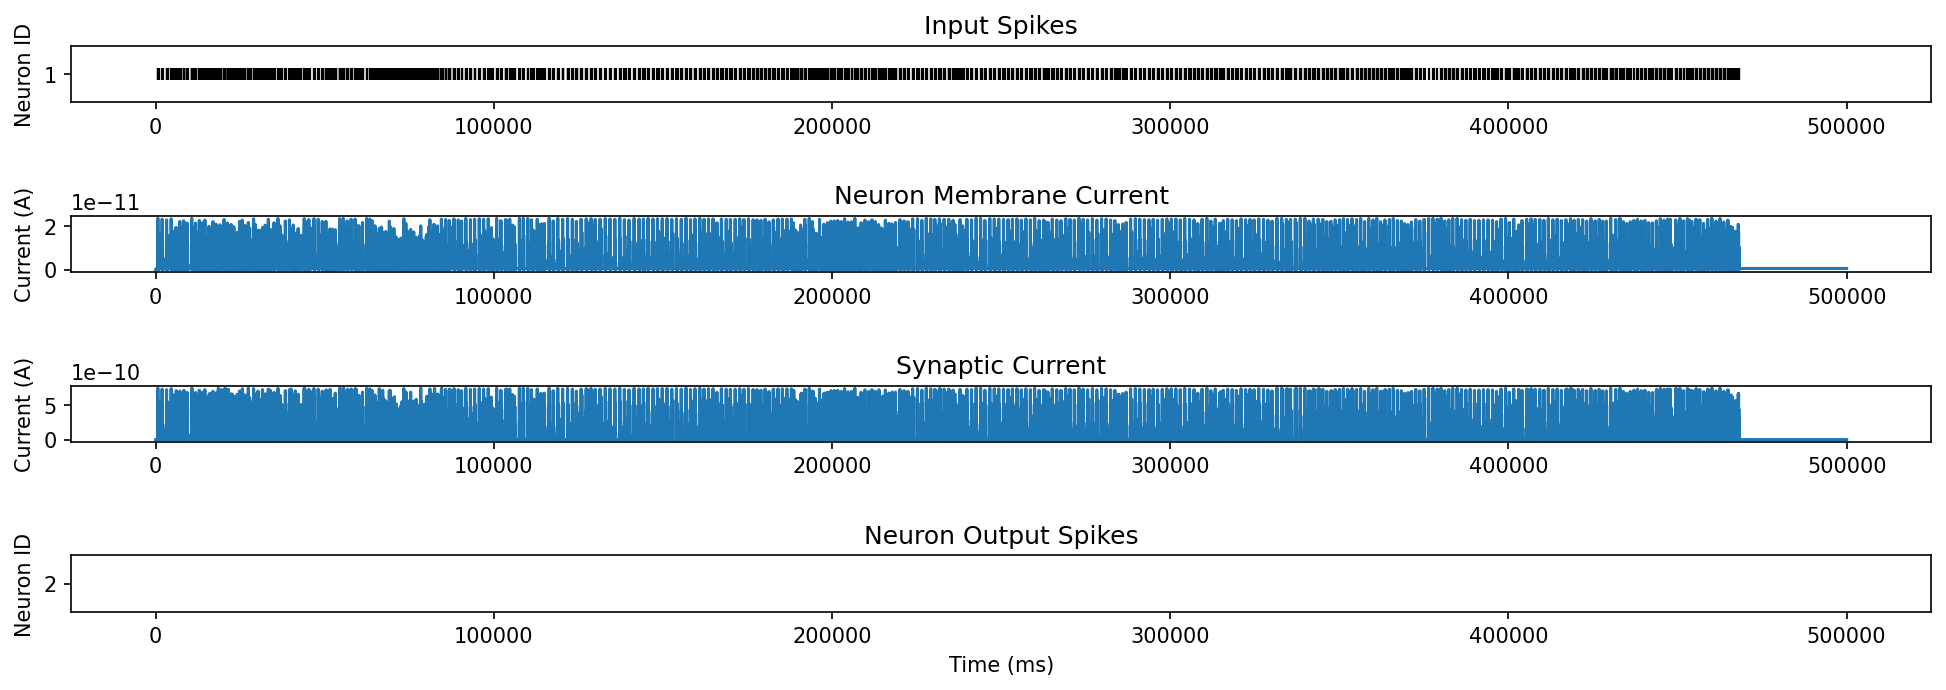

In [58]:
# plotting
plt.figure(figsize=(16,5),dpi=150)
plt.subplots_adjust(hspace=2)

times = int(duration/ms)

# Input Spikes 
plt.subplot(411)
spike_placeholder = np.zeros(times)
spike_placeholder[np.array(mon_neuron_input.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(0.5, 1.5)
plt.title('Input Spikes')
plt.ylabel('Neuron ID')
#plt.xlabel('Time (ms)')

plt.subplot(412)
Imem = mon_neuron_state.Imem[0]
plt.plot(mon_neuron_state.t/ms, Imem)

plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
#plt.xlabel('Time (ms)')

plt.subplot(413)
I_syn = mon_synapse_state.I_syn_exc2[0]
plt.plot(mon_neuron_state.t/ms, I_syn)

plt.title('Synaptic Current')
plt.ylabel('Current (A)')
#plt.xlabel('Time (ms)')

plt.subplot(414)
spike_placeholder = np.zeros(times)
spike_placeholder[np.array(mon_neuron_output.t/ms, dtype=int)]=2
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(1.5, 2.5)
plt.title('Neuron Output Spikes')
plt.ylabel('Neuron ID')
plt.xlabel('Time (ms)')
plt.show()

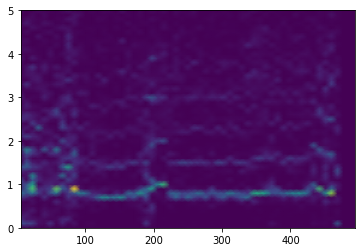

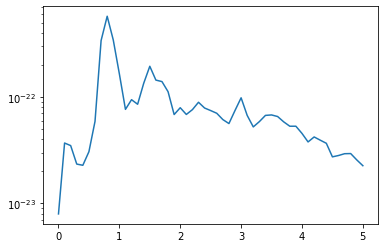

In [59]:
ts = mon_synapse_state.I_syn_exc2[0]
#ts = mon_neuron_state.Imem[0]
ts = ts - ts.mean()
fs = 10e5 / defaultclock.dt * us
nperseg = 2000

f, t, Sxx = signal.spectrogram(ts, fs, nperseg=nperseg)
_, Pxx_den = signal.welch(ts, fs, nperseg=nperseg)

fmin = 0 # Hz
fmax = 5 # Hz
freq_slice = np.where((f >= fmin) & (f <= fmax))

# keep only frequencies of interest
f   = f[freq_slice]
Sxx = Sxx[freq_slice,:][0]
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.show()


Pxx_den = Pxx_den[freq_slice]
plt.semilogy(f, Pxx_den)
plt.show()

In [ ]:
"""import pyaudio

p = pyaudio.PyAudio()

volume = 5000000
fs = int(10e5 / 20)     # sampling rate, Hz, must be integer

ts_sample = (ts * volume).astype(np.float32).tobytes()

# for paFloat32 sample values must be in range [-1.0, 1.0]
stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=fs,
                output=True)

# play. May repeat with different volume values (if done interactively) 
stream.write(ts_sample)

stream.stop_stream()
stream.close()

p.terminate()"""